# Method: RNN
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial

import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [4]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [5]:
train.data = train.data[:18000]
train.time = train.time[:18000]

In [6]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (18000, 40)
Test size: (90000, 40)


**Create test set**

In [7]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [8]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 2000 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [9]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. RNN Implementation

In [10]:
def RNN(h_dim, data_dim, alpha = 1, W_init = glorot_normal(), b_init = normal()):
    """
    args:
    ====
     h_dim: dimension of the internal state
     data_dim: dimensionity of the time series

    outputs:
    ======
     init_fun: function to initialize the parameters
     process: function to process a time-series and compute the final prediction and final internal state
     forecast: function that, given a pair (internal-state, input), computes the next T predictions
    """

    def init_fun(rng):
        """
        This function initialize the weights of the RNN

        args:
        ====
         rng: jax RNG

        outputs:
        ======
         params: a tuple of parameters
        """

        k1, k2, k3, k4, k5 = jax.random.split(rng, num = 5)
        W_in   = W_init(k1, (h_dim, data_dim))  # data to internal-state
        W_out  = W_init(k2, (data_dim, h_dim))  # internal-state to output 
        W_h    = W_init(k3, (h_dim, h_dim))     # internal-state to internal-state
        h_bias = b_init(k4, (h_dim, ))
        W_bias = b_init(k5, (data_dim, ))

        params = (W_in, W_out, W_h, h_bias, W_bias)
        return params

    def process(params, time_series):
        """
        This function takes a time-series in input, pass it through the RNN, 
        and finally outputs the last prediction and internal state

        args:
        ====
         params: tuple of parameters
         time_series: data of dimension (T, dim_data)

        outputs:
        =======
         h_last: jax vector of dimension nn_size
         pred_traj[-1]: last prediction
        """
        # extract parameters
        W_in, W_out, W_h, h_bias, W_bias = params

        # initial hidden state is set to zero
        h_zero = jnp.zeros((h_dim, ))

        # forward pass
        # RNN: internal function to process data
        def process_internal(hidden, x):
            h_new = (1-alpha)*hidden + alpha * jnp.tanh( W_h@hidden + W_in@x + h_bias)
            #out   = W_out@jnp.concatenate([h_new, jnp.tanh(x)])
            out   = x + W_out @ h_new + W_bias
            return h_new, out
        h_final, pred_traj = jax.lax.scan(process_internal, h_zero, time_series)

        return h_final, pred_traj[-1]

    def forecast(params, h_internal, x_input, horizon):
        """
        This function takes in an internal state and a first input and produces 
        prediction over a finite horizon.

        args:
        ====
         params: tuple of parameters
         h_internal:
         x_input: jax vector of dimension dim_data
         horizon: horizon of the prediction

        outputs:
        =======
         preds: a trajectory of prediction of dimension (horison, dim_data) 
        """
        # extract parameters
        W_in, W_out, W_h, h_bias, W_bias = params

        # forward pass
        # RNN: internal function to process data
        def forecast_internal(pair_h_x, _ ):
            hidden, x = pair_h_x
            h_new = (1-alpha) * hidden + alpha * jnp.tanh( W_h @ hidden + W_in @ x + h_bias)
            out   = x + W_out @ h_new + W_bias
            return (h_new, out), out 
        _, pred_traj = jax.lax.scan(forecast_internal, (h_internal, x_input), None, length=horizon)

        # return the trajectory of predictions
        return pred_traj

    return init_fun, process, forecast

In [11]:
def get_parameters(nn_size, seed, batch_size, L_past, L_forecast_train, 
                   num_epoch, lr_schedule, early_stopping = EARLY_STOPPING, 
                  early_stopping_baseline = 1.2):
    assert len(num_epoch) == len(lr_schedule)
    def training(x, y, init_params):
        @jax.jit
        def step(i, opt_state, x_batch, y_batch):
            params = get_params(opt_state)
            value, g = jax.value_and_grad(mse)(params, x_batch, y_batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        @partial(jax.jit, static_argnums=2)
        def make_forecast(params, x_batch, horizon):
            # pass the data through the RNN. 
            # note that "preds" is the first forecasts
            hs, preds = process_batch(params, x_batch)
            # compute the (L_forecast-1) next forecasts
            y_pred = forecast_batch(params, hs, preds, horizon-1)
            #stick all the forecasts together
            y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

            return y_pred

        @jax.jit
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE.

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast)

            #compute MSE
            error = y_pred - y_truth
            mu_loss = jnp.mean(error**2)
            return mu_loss 
        
        start = time()
                
        loss_train_traj = []
        loss_train_all_traj = []
        
        best_params = init_params
        overall_best_mse = 999999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + L_past))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(L_past)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(L_past,L_past+L_forecast_test)[None,:]).astype(int) 
        x_val = data_test[t_past_batch_val]
        y_val = data_test[t_pred_batch_val]
        
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the training data
                T_indices = np.arange(t_size - (L_forecast_train + L_past))
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch
                    # create 2d array of dimension (batch_size, L_past) containing all the time indices
                    t_past_batch = (t_start[:,None] + np.arange(L_past)[None,:]).astype(int) # transposes data
                    t_pred_batch = (t_start[:,None] + np.arange(L_past,L_past+L_forecast_train)[None,:]).astype(int) 

                    #create batch of dimension (batch_size, L_past, data_dim)
                    x_batch = x[t_past_batch]  
                    y_batch = y[t_pred_batch]

                    params, opt_state, loss_current = step(k, opt_state, x_batch, y_batch) # update
                    loss_epoch_train.append(loss_current)
                
                mse_train = np.mean(loss_epoch_train)
                
                # validation             
                mse_val = mse(params, x_val, y_val)
                
                if  best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 50):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                
                if best_mse < early_stopping_baseline and counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return overall_best_params

    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    # Initialize RNN
    init_fun, process, forecast = RNN(nn_size, data_dim)       # RNN Network
    process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
    forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
    init_params = init_fun(key)
    
    final_params = training(x, y, init_params)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return final_params, (process_batch, forecast_batch)

In [12]:
def get_test_pred(data_test, params, rnn_fx):  
    @partial(jax.jit, static_argnums=2)
    def make_forecast(params, x_batch, horizon):
        pbatch, fbatch = rnn_fx
        # pass the data through the RNN. 
        # note that "preds" is the first forecasts
        hs, preds = pbatch(params, x_batch)
        # compute the (L_forecast-1) next forecasts
        y_pred = fbatch(params, hs, preds, horizon-1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

        return y_pred

    @jax.jit
    def loss(params, x_batch, y_truth):
        """
        For each time-series in a batch, forecasts over a finite horizon 
        and compute the MSE.

        args:
        ====
         params: neural parameters
         x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
         y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

        outputs:
        =======
         MSE: MSE between forecasts and targets

        """

        # horizon of the forecast
        L_forecast = y_truth.shape[1]    
        y_pred = make_forecast(params, x_batch, L_forecast)

        #compute MSE
        error = y_pred - y_truth
        return jnp.mean(error**2)
    
    start = time()
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data
    mu_pred = make_forecast(params, data_test, L_forecast_test)
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mu_pred)

# 3. Parameter tuning

There are 3 parameters to tune
- nn_size [100, 500, 1000, 1500] - size of the hidden layer
- L_forecast_train [4, 8, 16] - steps forward considered when calculating loss during training
- L_past [1, 8, 16] - length of time series used as input during training 

As a full grid search will be computationally expensive, nn_size is first tuned using a fixed L_forecast_train and L_past, then a grid search is performed on the optimal nn_size

## 3.1 nn_size

**Parameters**
- nn_size = [100, 500, 1000, 1500]
- L_forecast_train = 8
- L_past = 4

In [12]:
L_forecast_train = 8
L_past = 4
b_size = 128 # Batch size
lr_list = [1e-2, 1e-3, 1e-4] # Learning rate schedule
epoch_list = [200, 400, 200]  # Number of epochs for each learning rate

### 3.1.1 nn_size = 100

In [13]:
nn_size = 100

In [14]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,)

Backpropogation start

Epoch 10: Time taken = 0.37 | Train loss = 0.0556873 | Val loss =  100.6466446
Epoch 20: Time taken = 0.41 | Train loss = 0.0448802 | Val loss =  335.3908997
Epoch 30: Time taken = 0.55 | Train loss = 0.0338479 | Val loss =  407.4849548
Epoch 40: Time taken = 0.34 | Train loss = 0.0241395 | Val loss =  318.7037048
Epoch 50: Time taken = 0.35 | Train loss = 0.0186283 | Val loss =  203.2743988
Epoch 60: Time taken = 0.58 | Train loss = 0.0149051 | Val loss =  177.7699738
Epoch 70: Time taken = 0.34 | Train loss = 0.0127374 | Val loss =  140.5262604
Epoch 80: Time taken = 0.34 | Train loss = 0.0116429 | Val loss =  99.9293976
Epoch 90: Time taken = 0.35 | Train loss = 0.0108087 | Val loss =  112.6202469
Epoch 100: Time taken = 0.35 | Train loss = 0.0101996 | Val loss =  122.7155609
Epoch 110: Time taken = 0.35 | Train loss = 0.0094791 | Val loss =  67.4849319
Epoch 120: Time taken = 0.40 | Train loss = 0.0090067 | Val loss =  98.3972397
Epoch 130: Time taken = 0.47 

In [16]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_1_1_mu_preds.pkl")

Testing complete. Time taken: 0.33


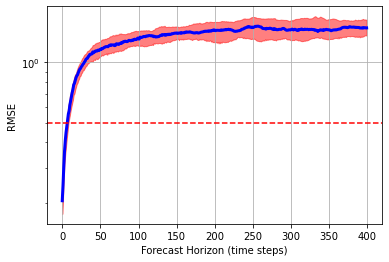

It takes around t = 0.07 for mean error to exceed 0.5


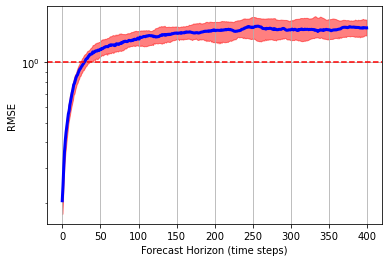

It takes around t = 0.29 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.867
Median NRMSE at t = 0.5: 1.164
Median NRMSE at t = 1: 1.307
Median NRMSE at t = 2: 1.448
Median NRMSE at t = 3: 1.456


In [17]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 500

In [18]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

In [19]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.31 | Train loss = 0.0404124 | Val loss =  2433.9804688
Epoch 20: Time taken = 0.31 | Train loss = 0.0223796 | Val loss =  3541.8125000
Epoch 30: Time taken = 0.34 | Train loss = 0.0145759 | Val loss =  3523.9372559
Epoch 40: Time taken = 0.35 | Train loss = 0.0108180 | Val loss =  2871.1228027
Epoch 50: Time taken = 0.32 | Train loss = 0.0083458 | Val loss =  2556.1591797
Epoch 60: Time taken = 0.38 | Train loss = 0.0068207 | Val loss =  1987.8199463
Epoch 70: Time taken = 0.32 | Train loss = 0.0056876 | Val loss =  1435.2445068
Epoch 80: Time taken = 0.34 | Train loss = 0.0049874 | Val loss =  1231.0332031
Epoch 90: Time taken = 0.31 | Train loss = 0.0044330 | Val loss =  1108.9193115
Epoch 100: Time taken = 0.33 | Train loss = 0.0038817 | Val loss =  827.0551147
Epoch 110: Time taken = 0.33 | Train loss = 0.0036683 | Val loss =  591.5560303
Epoch 120: Time taken = 0.33 | Train loss = 0.0032612 | Val loss =  487.1224060
Epoch 130: Time t

In [20]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_1_2_mu_preds.pkl")

Testing complete. Time taken: 0.43


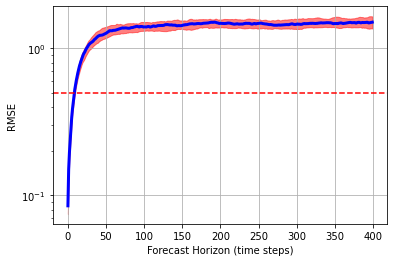

It takes around t = 0.09 for mean error to exceed 0.5


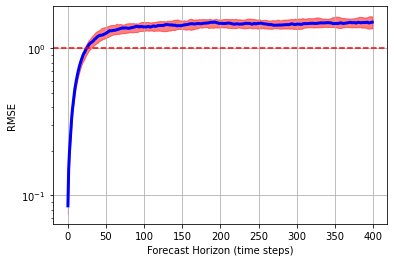

It takes around t = 0.25 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.903
Median NRMSE at t = 0.5: 1.268
Median NRMSE at t = 1: 1.402
Median NRMSE at t = 2: 1.484
Median NRMSE at t = 3: 1.467


In [21]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 1000

In [22]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1000

In [23]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.52 | Train loss = 0.0183423 | Val loss =  39.6207733
Epoch 20: Time taken = 0.53 | Train loss = 0.0087301 | Val loss =  16.1291790
Epoch 30: Time taken = 0.53 | Train loss = 0.0063560 | Val loss =  4.2176399
Epoch 40: Time taken = 0.53 | Train loss = 0.0053389 | Val loss =  2.7173259
Epoch 50: Time taken = 0.53 | Train loss = 0.0046305 | Val loss =  2.3038871
Epoch 60: Time taken = 0.53 | Train loss = 0.0036592 | Val loss =  2.1461017
Epoch 70: Time taken = 0.56 | Train loss = 0.0038627 | Val loss =  2.0113385
Epoch 77: Time taken = 0.53 | Train loss = 0.0031842 | Val loss =  1.9384540
Epoch 80: Time taken = 0.53 | Train loss = 0.0035224 | Val loss =  1.9180995
Epoch 86: Time taken = 0.53 | Train loss = 0.0030836 | Val loss =  1.8863977
Epoch 88: Time taken = 0.53 | Train loss = 0.0030095 | Val loss =  1.8536317
Epoch 90: Time taken = 0.53 | Train loss = 0.0026066 | Val loss =  1.8746754
Epoch 95: Time taken = 0.54 | Train loss = 0.002949

In [24]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_1_3_mu_preds.pkl")

Testing complete. Time taken: 0.53


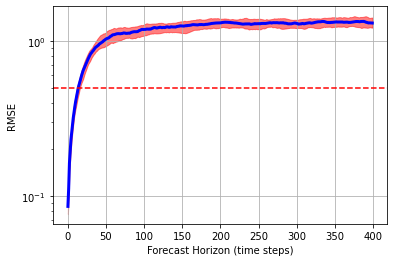

It takes around t = 0.14 for mean error to exceed 0.5


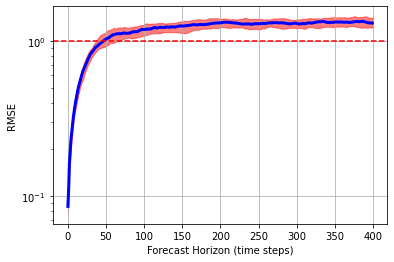

It takes around t = 0.47 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.646
Median NRMSE at t = 0.5: 1.033
Median NRMSE at t = 1: 1.191
Median NRMSE at t = 2: 1.314
Median NRMSE at t = 3: 1.303


In [25]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 1500

In [26]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1500

In [27]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.87 | Train loss = 0.0122666 | Val loss =  2.3039267
Epoch 20: Time taken = 0.87 | Train loss = 0.0067669 | Val loss =  2.1507354
Epoch 30: Time taken = 0.88 | Train loss = 0.0063417 | Val loss =  1.9716319
Epoch 40: Time taken = 0.87 | Train loss = 0.0059005 | Val loss =  1.8779655
Epoch 50: Time taken = 0.88 | Train loss = 0.0053219 | Val loss =  1.8093951
Epoch 52: Time taken = 0.87 | Train loss = 0.0051265 | Val loss =  1.7427152
Epoch 55: Time taken = 0.87 | Train loss = 0.0042255 | Val loss =  1.7100013
Epoch 60: Time taken = 0.87 | Train loss = 0.0042618 | Val loss =  1.7675143
Epoch 70: Time taken = 0.87 | Train loss = 0.0045914 | Val loss =  1.7251846
Epoch 71: Time taken = 0.88 | Train loss = 0.0040006 | Val loss =  1.6988539
Epoch 76: Time taken = 0.91 | Train loss = 0.0044683 | Val loss =  1.6856916
Epoch 77: Time taken = 0.88 | Train loss = 0.0039870 | Val loss =  1.6719991
Epoch 80: Time taken = 0.87 | Train loss = 0.0037719 

In [28]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_1_4_mu_preds.pkl")

Testing complete. Time taken: 0.61


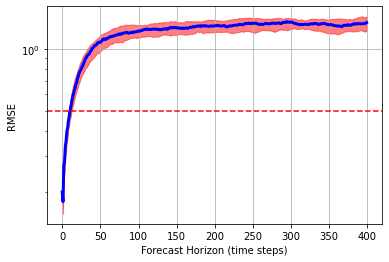

It takes around t = 0.11 for mean error to exceed 0.5


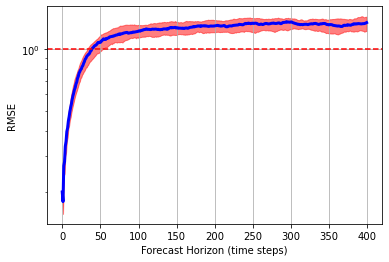

It takes around t = 0.39 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.719
Median NRMSE at t = 0.5: 1.076
Median NRMSE at t = 1: 1.222
Median NRMSE at t = 2: 1.295
Median NRMSE at t = 3: 1.353


In [29]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 L_forecast_train + L_past

**Parameters**
- nn_size = 1000
- L_forecast_train = [1, 8, 16]
- L_past = [4, 8, 16]

In [30]:
nn_size = 1000
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

### 3.2.1 L_forecast_train = 4, L_past = 1

In [31]:
L_forecast_train = 4; L_past = 1

In [32]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.22 | Train loss = 0.0107960 | Val loss =  4432.5786133
Epoch 20: Time taken = 0.22 | Train loss = 0.0060552 | Val loss =  4105.1674805
Epoch 30: Time taken = 0.22 | Train loss = 0.0045218 | Val loss =  4037.7023926
Epoch 40: Time taken = 0.22 | Train loss = 0.0037087 | Val loss =  3830.8105469
Epoch 50: Time taken = 0.21 | Train loss = 0.0032906 | Val loss =  3767.1315918
Epoch 60: Time taken = 0.22 | Train loss = 0.0028389 | Val loss =  3495.3618164
Epoch 70: Time taken = 0.22 | Train loss = 0.0025564 | Val loss =  3335.1030273
Epoch 80: Time taken = 0.22 | Train loss = 0.0023491 | Val loss =  3121.5007324
Epoch 90: Time taken = 0.22 | Train loss = 0.0021430 | Val loss =  3156.8525391
Epoch 100: Time taken = 0.22 | Train loss = 0.0020098 | Val loss =  3027.8249512
Epoch 110: Time taken = 0.22 | Train loss = 0.0018920 | Val loss =  2812.7512207
Epoch 120: Time taken = 0.22 | Train loss = 0.0018161 | Val loss =  2777.7907715
Epoch 130: Tim

In [33]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_1_mu_preds.pkl")

Testing complete. Time taken: 0.39


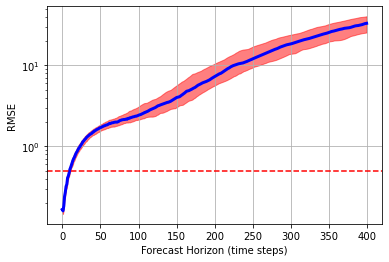

It takes around t = 0.10 for mean error to exceed 0.5


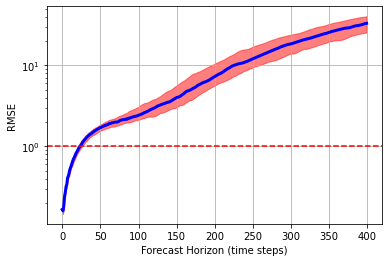

It takes around t = 0.24 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.881
Median NRMSE at t = 0.5: 1.701
Median NRMSE at t = 1: 2.430
Median NRMSE at t = 2: 7.312
Median NRMSE at t = 3: 18.514


In [34]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 L_forecast_train = 4, L_past = 4

In [35]:
L_forecast_train = 4; L_past = 4

In [36]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.36 | Train loss = 0.0039330 | Val loss =  13593.1943359
Epoch 20: Time taken = 0.37 | Train loss = 0.0024154 | Val loss =  14534.1259766
Epoch 30: Time taken = 0.37 | Train loss = 0.0021429 | Val loss =  12195.6259766
Epoch 40: Time taken = 0.37 | Train loss = 0.0018799 | Val loss =  10219.9531250
Epoch 50: Time taken = 0.37 | Train loss = 0.0015898 | Val loss =  8460.7714844
Epoch 60: Time taken = 0.36 | Train loss = 0.0014024 | Val loss =  6656.5014648
Epoch 70: Time taken = 0.37 | Train loss = 0.0013312 | Val loss =  5652.0322266
Epoch 80: Time taken = 0.37 | Train loss = 0.0011562 | Val loss =  4986.4228516
Epoch 90: Time taken = 0.36 | Train loss = 0.0011074 | Val loss =  4008.7231445
Epoch 100: Time taken = 0.37 | Train loss = 0.0008983 | Val loss =  3543.9565430
Epoch 110: Time taken = 0.37 | Train loss = 0.0008598 | Val loss =  3301.0234375
Epoch 120: Time taken = 0.37 | Train loss = 0.0008729 | Val loss =  2649.8142090
Epoch 130:

In [37]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_2_mu_preds.pkl")

Testing complete. Time taken: 0.41


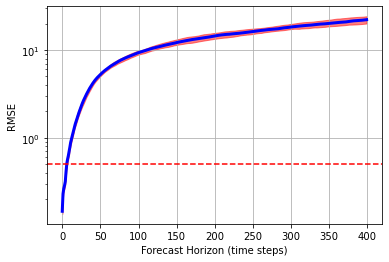

It takes around t = 0.06 for mean error to exceed 0.5


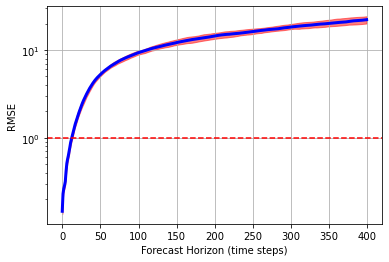

It takes around t = 0.13 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 1.727
Median NRMSE at t = 0.5: 5.283
Median NRMSE at t = 1: 9.331
Median NRMSE at t = 2: 14.454
Median NRMSE at t = 3: 18.290


In [38]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.3 L_forecast_train = 4, L_past = 8

In [39]:
L_forecast_train = 4; L_past = 8

In [40]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.52 | Train loss = 0.0029954 | Val loss =  4191.1069336
Epoch 20: Time taken = 0.52 | Train loss = 0.0018023 | Val loss =  4645.2348633
Epoch 30: Time taken = 0.52 | Train loss = 0.0016061 | Val loss =  2399.9323730
Epoch 40: Time taken = 0.52 | Train loss = 0.0014918 | Val loss =  1049.4582520
Epoch 50: Time taken = 0.52 | Train loss = 0.0013981 | Val loss =  340.0488892
Epoch 51: Time taken = 0.52 | Train loss = 0.0013664 | Val loss =  311.3237610
Epoch 52: Time taken = 0.52 | Train loss = 0.0012368 | Val loss =  274.2543335
Epoch 53: Time taken = 0.52 | Train loss = 0.0012319 | Val loss =  250.7474365
Epoch 54: Time taken = 0.52 | Train loss = 0.0011720 | Val loss =  231.9876556
Epoch 55: Time taken = 0.52 | Train loss = 0.0011827 | Val loss =  230.4769592
Epoch 56: Time taken = 0.52 | Train loss = 0.0012134 | Val loss =  185.8970642
Epoch 57: Time taken = 0.52 | Train loss = 0.0011810 | Val loss =  151.0759735
Epoch 58: Time taken = 0.

In [41]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_3_mu_preds.pkl")

Testing complete. Time taken: 0.53


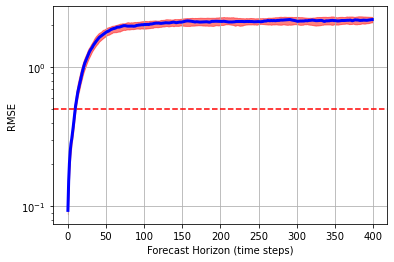

It takes around t = 0.10 for mean error to exceed 0.5


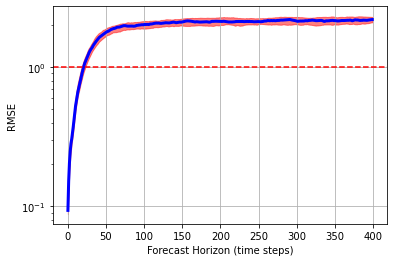

It takes around t = 0.21 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.972
Median NRMSE at t = 0.5: 1.778
Median NRMSE at t = 1: 2.021
Median NRMSE at t = 2: 2.128
Median NRMSE at t = 3: 2.139


In [42]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 L_forecast_train = 8, L_past = 1

In [43]:
L_forecast_train = 8; L_past = 1

In [44]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.39 | Train loss = 0.0239546 | Val loss =  2215.2626953
Epoch 20: Time taken = 0.39 | Train loss = 0.0120110 | Val loss =  2507.6984863
Epoch 30: Time taken = 0.39 | Train loss = 0.0090786 | Val loss =  2430.5673828
Epoch 40: Time taken = 0.39 | Train loss = 0.0069893 | Val loss =  2161.5214844
Epoch 50: Time taken = 0.39 | Train loss = 0.0061873 | Val loss =  2020.7762451
Epoch 60: Time taken = 0.39 | Train loss = 0.0053094 | Val loss =  1971.8779297
Epoch 70: Time taken = 0.39 | Train loss = 0.0049049 | Val loss =  1591.7960205
Epoch 80: Time taken = 0.39 | Train loss = 0.0045618 | Val loss =  1452.6586914
Epoch 90: Time taken = 0.39 | Train loss = 0.0045354 | Val loss =  1363.5435791
Epoch 100: Time taken = 0.39 | Train loss = 0.0037182 | Val loss =  1202.7087402
Epoch 110: Time taken = 0.39 | Train loss = 0.0036297 | Val loss =  990.7821655
Epoch 120: Time taken = 0.39 | Train loss = 0.0040001 | Val loss =  1009.8532715
Epoch 130: Time

In [45]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 0.36


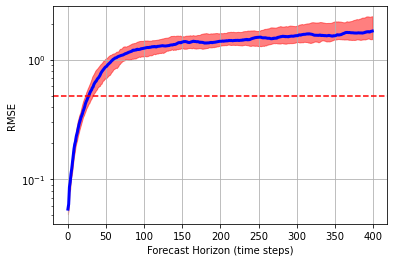

It takes around t = 0.28 for mean error to exceed 0.5


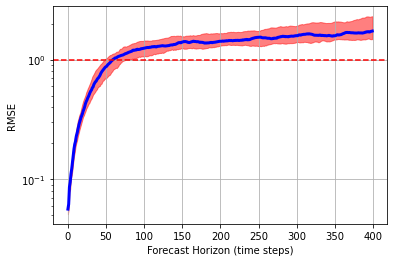

It takes around t = 0.59 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.372
Median NRMSE at t = 0.5: 0.876
Median NRMSE at t = 1: 1.251
Median NRMSE at t = 2: 1.426
Median NRMSE at t = 3: 1.587


In [46]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 L_forecast_train = 8, L_past = 4

In [47]:
L_forecast_train = 8; L_past = 4

In [48]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.53 | Train loss = 0.0183423 | Val loss =  39.6207733
Epoch 20: Time taken = 0.54 | Train loss = 0.0087301 | Val loss =  16.1291790
Epoch 30: Time taken = 0.54 | Train loss = 0.0063560 | Val loss =  4.2176399
Epoch 40: Time taken = 0.54 | Train loss = 0.0053389 | Val loss =  2.7173259
Epoch 50: Time taken = 0.53 | Train loss = 0.0046305 | Val loss =  2.3038871
Epoch 60: Time taken = 0.53 | Train loss = 0.0036592 | Val loss =  2.1461017
Epoch 70: Time taken = 0.54 | Train loss = 0.0038627 | Val loss =  2.0113385
Epoch 77: Time taken = 0.53 | Train loss = 0.0031842 | Val loss =  1.9384540
Epoch 80: Time taken = 0.53 | Train loss = 0.0035224 | Val loss =  1.9180995
Epoch 86: Time taken = 0.53 | Train loss = 0.0030836 | Val loss =  1.8863977
Epoch 88: Time taken = 0.54 | Train loss = 0.0030095 | Val loss =  1.8536317
Epoch 90: Time taken = 0.54 | Train loss = 0.0026066 | Val loss =  1.8746754
Epoch 95: Time taken = 0.53 | Train loss = 0.002949

In [49]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_5_mu_preds.pkl")

Testing complete. Time taken: 0.38


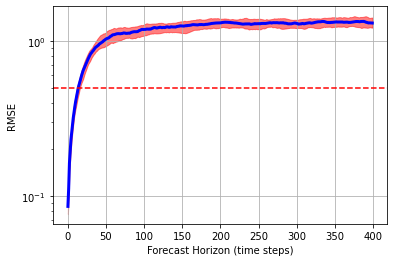

It takes around t = 0.14 for mean error to exceed 0.5


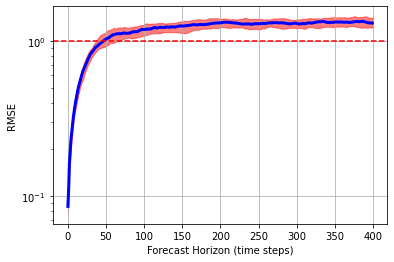

It takes around t = 0.47 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.646
Median NRMSE at t = 0.5: 1.033
Median NRMSE at t = 1: 1.191
Median NRMSE at t = 2: 1.314
Median NRMSE at t = 3: 1.303


In [50]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.6 L_forecast_train = 8, L_past = 8

In [51]:
L_forecast_train = 8; L_past = 8

In [52]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.70 | Train loss = 0.0129429 | Val loss =  73.3880539
Epoch 20: Time taken = 0.70 | Train loss = 0.0069463 | Val loss =  44.7075043
Epoch 30: Time taken = 0.70 | Train loss = 0.0058174 | Val loss =  10.0674105
Epoch 40: Time taken = 0.70 | Train loss = 0.0049380 | Val loss =  6.1263680
Epoch 50: Time taken = 0.70 | Train loss = 0.0047702 | Val loss =  4.0254998
Epoch 60: Time taken = 0.70 | Train loss = 0.0038208 | Val loss =  3.2243133
Epoch 70: Time taken = 0.70 | Train loss = 0.0034032 | Val loss =  2.8224938
Epoch 80: Time taken = 0.70 | Train loss = 0.0030744 | Val loss =  2.3876340
Epoch 90: Time taken = 0.70 | Train loss = 0.0031328 | Val loss =  2.1788723
Epoch 100: Time taken = 0.69 | Train loss = 0.0023348 | Val loss =  2.0670211
Epoch 110: Time taken = 0.70 | Train loss = 0.0023214 | Val loss =  1.9427371
Epoch 120: Time taken = 0.69 | Train loss = 0.0024775 | Val loss =  1.9035879
Epoch 130: Time taken = 0.70 | Train loss = 0.0

In [53]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_6_mu_preds.pkl")

Testing complete. Time taken: 0.37


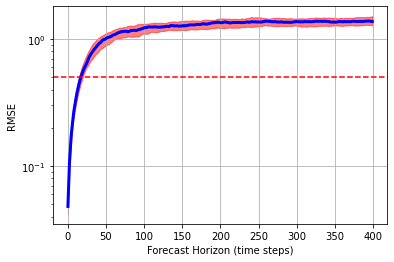

It takes around t = 0.17 for mean error to exceed 0.5


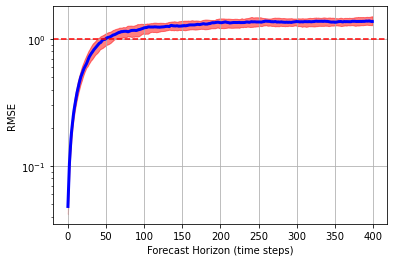

It takes around t = 0.50 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.564
Median NRMSE at t = 0.5: 1.008
Median NRMSE at t = 1: 1.225
Median NRMSE at t = 2: 1.344
Median NRMSE at t = 3: 1.373


In [54]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.7 L_forecast_train = 16, L_past = 1

In [55]:
L_forecast_train = 16; L_past = 1

In [56]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.73 | Train loss = 0.0955983 | Val loss =  4.6474981
Epoch 20: Time taken = 0.72 | Train loss = 0.0422937 | Val loss =  124.4372253
Epoch 30: Time taken = 0.72 | Train loss = 0.0286172 | Val loss =  579.2608032
EARLY STOPPING. Epoch 33: Train loss = 0.0271536 | Val loss =  322.5369568
Best Validation MSE: 1.0259033
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.73 | Train loss = 0.0532342 | Val loss =  1.3420861
Epoch 20: Time taken = 0.72 | Train loss = 0.0288840 | Val loss =  1.8246703
Epoch 30: Time taken = 0.73 | Train loss = 0.0218404 | Val loss =  2.5385227
EARLY STOPPING. Epoch 32: Train loss = 0.0211539 | Val loss =  2.4740200
Best Validation MSE: 0.9023039
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 0.73 | Train loss = 0.0326562 | Val loss =  1.3979560
Epoch 20: Time taken = 0.72 | Train loss = 0.0242693 | Val loss =  1.5756845
Epoch 30: Time taken = 0.72 | Train loss = 0.0203787 | Val loss =  1.9642272
EARLY STOPPING. Epoc

In [57]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_7_mu_preds.pkl")

Testing complete. Time taken: 0.37


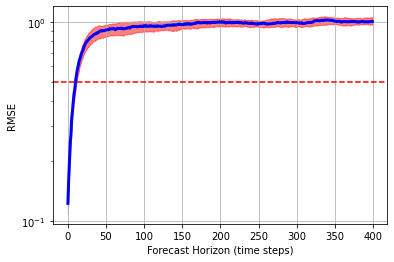

It takes around t = 0.10 for mean error to exceed 0.5


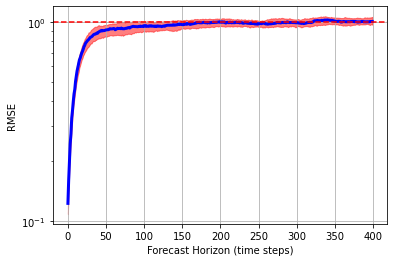

It takes around t = 1.99 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.727
Median NRMSE at t = 0.5: 0.911
Median NRMSE at t = 1: 0.949
Median NRMSE at t = 2: 0.996
Median NRMSE at t = 3: 0.992


In [58]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.8 L_forecast_train = 16, L_past = 4

In [59]:
L_forecast_train = 16; L_past = 4

In [60]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.87 | Train loss = 0.0648809 | Val loss =  1.9008205
Epoch 20: Time taken = 0.87 | Train loss = 0.0258773 | Val loss =  1.9939772
Epoch 30: Time taken = 0.87 | Train loss = 0.0178082 | Val loss =  1.9604148
Epoch 40: Time taken = 0.87 | Train loss = 0.0153266 | Val loss =  1.8554466
Epoch 50: Time taken = 0.87 | Train loss = 0.0133120 | Val loss =  1.8020414
Epoch 56: Time taken = 0.87 | Train loss = 0.0103210 | Val loss =  1.7195125
Epoch 60: Time taken = 0.87 | Train loss = 0.0110728 | Val loss =  1.7499862
Epoch 63: Time taken = 0.87 | Train loss = 0.0112442 | Val loss =  1.7184132
Epoch 64: Time taken = 0.87 | Train loss = 0.0100031 | Val loss =  1.7152702
Epoch 65: Time taken = 0.87 | Train loss = 0.0100642 | Val loss =  1.7133927
Epoch 70: Time taken = 0.87 | Train loss = 0.0094775 | Val loss =  1.7323523
Epoch 71: Time taken = 0.86 | Train loss = 0.0084570 | Val loss =  1.7129102
Epoch 75: Time taken = 0.87 | Train loss = 0.0090290 

In [61]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_8_mu_preds.pkl")

Testing complete. Time taken: 0.36


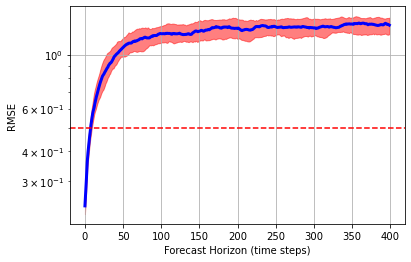

It takes around t = 0.08 for mean error to exceed 0.5


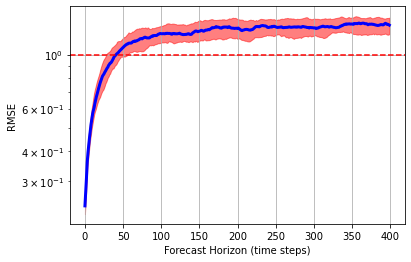

It takes around t = 0.41 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.766
Median NRMSE at t = 0.5: 1.073
Median NRMSE at t = 1: 1.221
Median NRMSE at t = 2: 1.283
Median NRMSE at t = 3: 1.290


In [62]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.9 L_forecast_train = 16, L_past = 8

In [63]:
L_forecast_train = 16; L_past = 8

In [64]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.01 | Train loss = 0.0917212 | Val loss =  1.9262915
Epoch 20: Time taken = 1.02 | Train loss = 0.0337102 | Val loss =  2.0565393
Epoch 30: Time taken = 1.02 | Train loss = 0.0200668 | Val loss =  2.0263941
Epoch 40: Time taken = 1.02 | Train loss = 0.0168129 | Val loss =  1.9243875
Epoch 50: Time taken = 1.02 | Train loss = 0.0135899 | Val loss =  1.8299299
Epoch 60: Time taken = 1.02 | Train loss = 0.0112268 | Val loss =  1.7870854
Epoch 70: Time taken = 1.02 | Train loss = 0.0104943 | Val loss =  1.7389227
Epoch 80: Time taken = 1.02 | Train loss = 0.0096696 | Val loss =  1.7245334
Epoch 86: Time taken = 1.02 | Train loss = 0.0079208 | Val loss =  1.6363485
Epoch 89: Time taken = 1.02 | Train loss = 0.0098575 | Val loss =  1.6133832
Epoch 90: Time taken = 1.02 | Train loss = 0.0089253 | Val loss =  1.6465901
Epoch 91: Time taken = 1.01 | Train loss = 0.0080016 | Val loss =  1.6043850
Epoch 97: Time taken = 1.01 | Train loss = 0.0064163 

In [65]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_9_mu_preds.pkl")

Testing complete. Time taken: 0.57


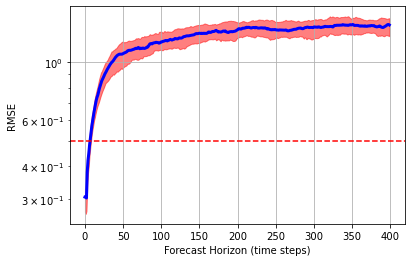

It takes around t = 0.07 for mean error to exceed 0.5


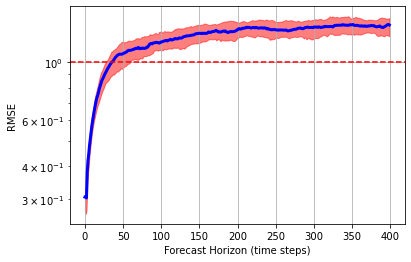

It takes around t = 0.36 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.812
Median NRMSE at t = 0.5: 1.081
Median NRMSE at t = 1: 1.198
Median NRMSE at t = 2: 1.333
Median NRMSE at t = 3: 1.366


In [66]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best Model

nn_size = 500  
L_forecast_train = 4  
L_past = 4

In [23]:
nn_size = 1000
L_forecast_train = 8
L_past = 1

b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5, 1e-6] # Learning rate schedule
epoch_list = [400, 400, 400, 400]  # Number of epochs for each learning rate

In [24]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,
                                early_stopping = 50)

Backpropogation start

Epoch 10: Time taken = 0.37 | Train loss = 0.0261647 | Val loss =  2299.8081055
Epoch 20: Time taken = 0.37 | Train loss = 0.0132663 | Val loss =  2516.9924316
Epoch 30: Time taken = 0.37 | Train loss = 0.0097553 | Val loss =  2419.7844238
Epoch 40: Time taken = 0.37 | Train loss = 0.0081218 | Val loss =  2273.2814941
Epoch 50: Time taken = 0.37 | Train loss = 0.0069253 | Val loss =  2383.0720215
Epoch 60: Time taken = 0.37 | Train loss = 0.0060698 | Val loss =  1851.8701172
Epoch 70: Time taken = 0.37 | Train loss = 0.0054561 | Val loss =  2024.0484619
Epoch 80: Time taken = 0.37 | Train loss = 0.0048843 | Val loss =  1685.4722900
Epoch 90: Time taken = 0.37 | Train loss = 0.0043579 | Val loss =  1519.4427490
Epoch 100: Time taken = 0.37 | Train loss = 0.0039261 | Val loss =  1381.6660156
Epoch 110: Time taken = 0.37 | Train loss = 0.0037873 | Val loss =  1363.0235596
Epoch 120: Time taken = 0.37 | Train loss = 0.0037561 | Val loss =  1087.4344482
Epoch 130: Tim

In [25]:
mean_pred = get_test_pred(X_test, params, rnn_fx)

Testing complete. Time taken: 0.39


In [26]:
save_obj(params, "results/rnn", "best_params.pkl")
save_obj(mean_pred, "results/rnn", "best_mu_preds.pkl")

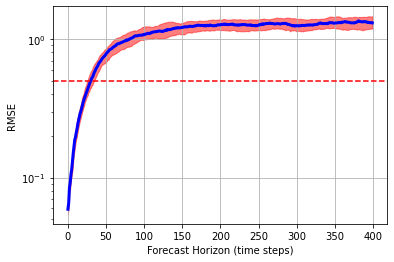

It takes around t = 0.31 for mean error to exceed 0.5


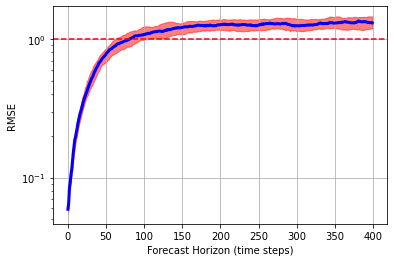

It takes around t = 0.81 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.350
Median NRMSE at t = 0.5: 0.780
Median NRMSE at t = 1: 1.074
Median NRMSE at t = 2: 1.264
Median NRMSE at t = 3: 1.247


In [27]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [13]:
nn_size = 1000
_, process, forecast = RNN(nn_size, data_dim)       # RNN Network
process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)

In [14]:
params = load_obj("results/rnn/best_params.pkl")

In [15]:
mean_pred = get_test_pred(X_test, params, (process_batch, forecast_batch))
save_obj(mean_pred, "results", "rnn_pred.pkl")

Testing complete. Time taken: 1.52


In [10]:
mean_pred = load_obj("results/rnn_pred.pkl")

In [11]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

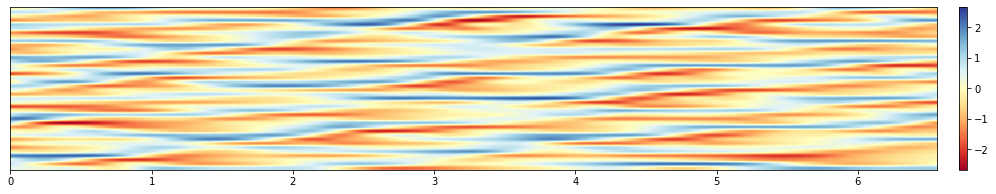

In [15]:
plt.figure(figsize = (20, 3))
plt.imshow(y_test[0].T, cmap = "RdYlBu", aspect = "auto", extent = [0, total_lyapunov_time_pred, 0, 40])
plt.tick_params(axis='both', which='both', left = False, labelleft = False,) 
plt.colorbar(pad = 0.02)
# plt.xlabel("Lyapunov Time")
# plt.title("Actual")
plt.savefig("lorenz_small_actual.png", facecolor = "white", bbox_inches = "tight")
plt.show()

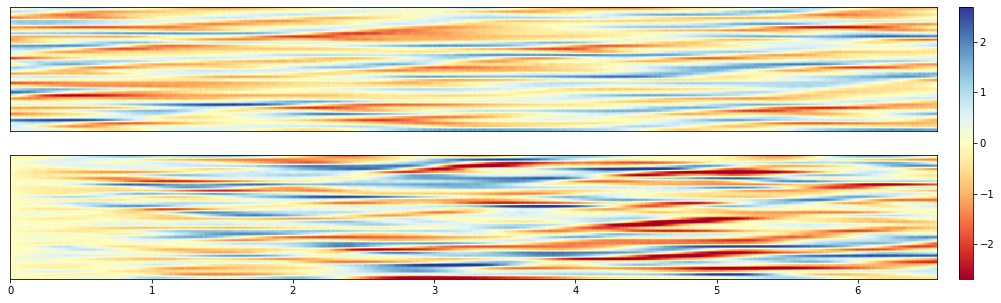

In [13]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "lorenz_small_rnn", pred_only = True)

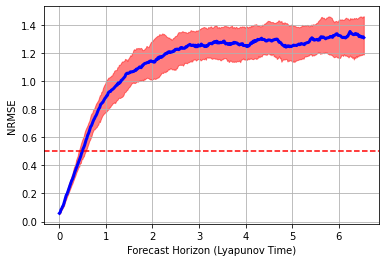

It takes around 0.51 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.499
Median NRMSE at 1.0 Lyapunov Time: 0.884
Median NRMSE at 2.0 Lyapunov Time: 1.137
Median NRMSE at 5.0 Lyapunov Time: 1.248


In [21]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "lorenz_small_rnn_ph")
print()
res_single.get_loss()